# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


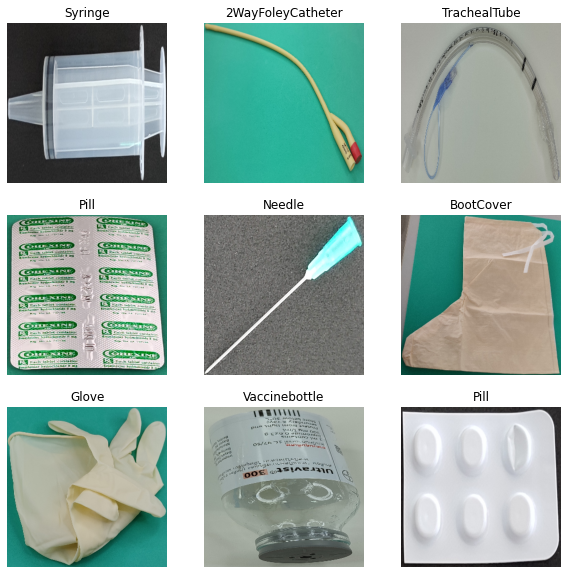

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                5289      
Total params: 22,070,345
Trainable params: 267,561
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

4


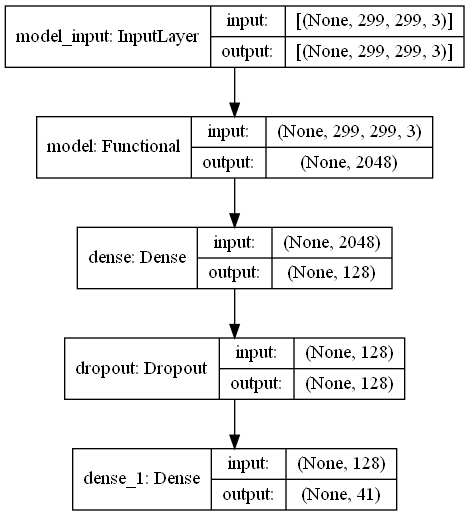

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 43s 329ms/step - loss: 1.7724 - accuracy: 0.5570 - val_loss: 0.8693 - val_accuracy: 0.7697
Epoch 2/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.7149 - accuracy: 0.8019 - val_loss: 0.4788 - val_accuracy: 0.8913
Epoch 3/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.4106 - accuracy: 0.8895 - val_loss: 0.3316 - val_accuracy: 0.9314
Epoch 4/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.2911 - accuracy: 0.9267 - val_loss: 0.2859 - val_accuracy: 0.9250
Epoch 5/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.2151 - accuracy: 0.9489 - val_loss: 0.2384 - val_accuracy: 0.9353
Epoch 6/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.1598 - accuracy: 0.9619 - val_loss: 0.2041 - val_accuracy: 0.9470
Epoch 7/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.1307 - accuracy: 0.9745 - val_loss: 0.1928 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

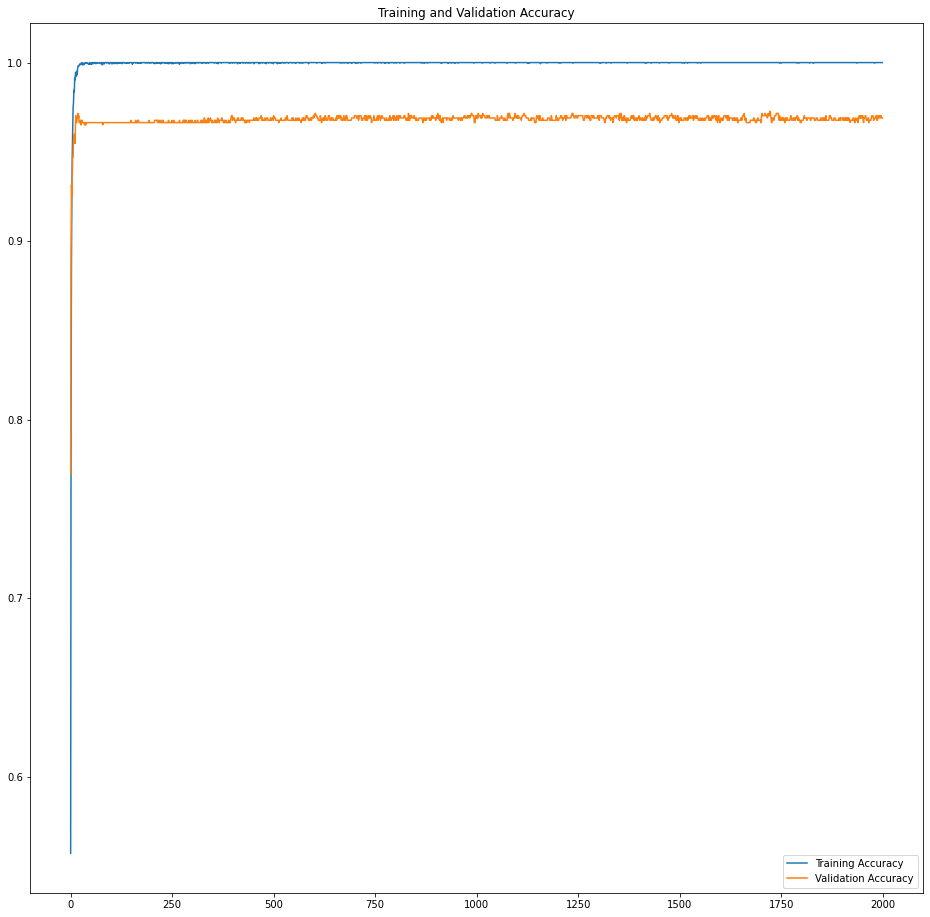

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


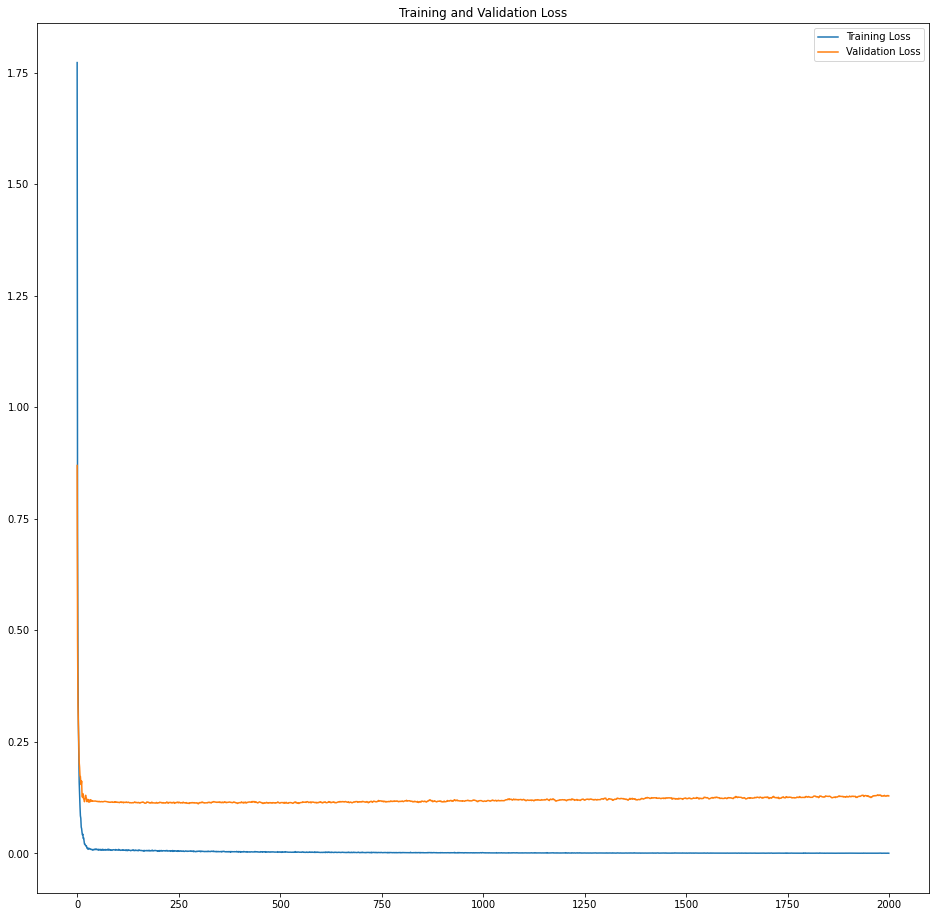

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 341ms/step - loss: 0.6175 - accuracy: 0.8467
test_indoor_ds_results:test loss, test acc: [0.6174708604812622, 0.846711277961731]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 25s 413ms/step - loss: 1.6769 - accuracy: 0.7392
test_outdoor_ds_results:test loss, test acc: [1.6769237518310547, 0.7391719818115234]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 192ms/step - loss: 1.9214 - accuracy: 0.6995
test_belt_ds_results:test loss, test acc: [1.9213933944702148, 0.6994560360908508]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteChe

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 132ms/step - loss: 1.4681 - accuracy: 0.6872
Epoch040 
 test_indoor_acc=0.8361204266548157 
 test_outdoor_acc=0.734394907951355 
 test_belt_acc=0.6872166991233826
35/35 [==============================] - 5s 131ms/step - loss: 1.4638 - accuracy: 0.6890
Epoch080 
 test_indoor_acc=0.8422519564628601 
 test_outdoor_acc=0.7391719818115234 
 test_belt_acc=0.6890299320220947
35/35 [==============================] - 5s 132ms/step - loss: 1.4799 - accuracy: 0.6890
Epoch120 
 test_indoor_acc=0.8416945338249207 
 test_outdoor_acc=0.7375796437263489 
 test_belt_acc=0.6890299320220947
35/35 [==============================] - 5s 130ms/step - loss: 1.4842 - accuracy: 0.6872
Epoch160 
 test_indoor_acc=0.8405796885490417 
 test_outdoor_acc=0.7369426488876343 
 test_belt_acc=0.6872166991233826
35/35 [==============================] - 5s 132ms/step - loss: 1.5015 - accuracy: 0.6877
Epoch200 
 test_indoor_acc=0.8400223255157471 
 test_outdoor_acc=0.7363057136535

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

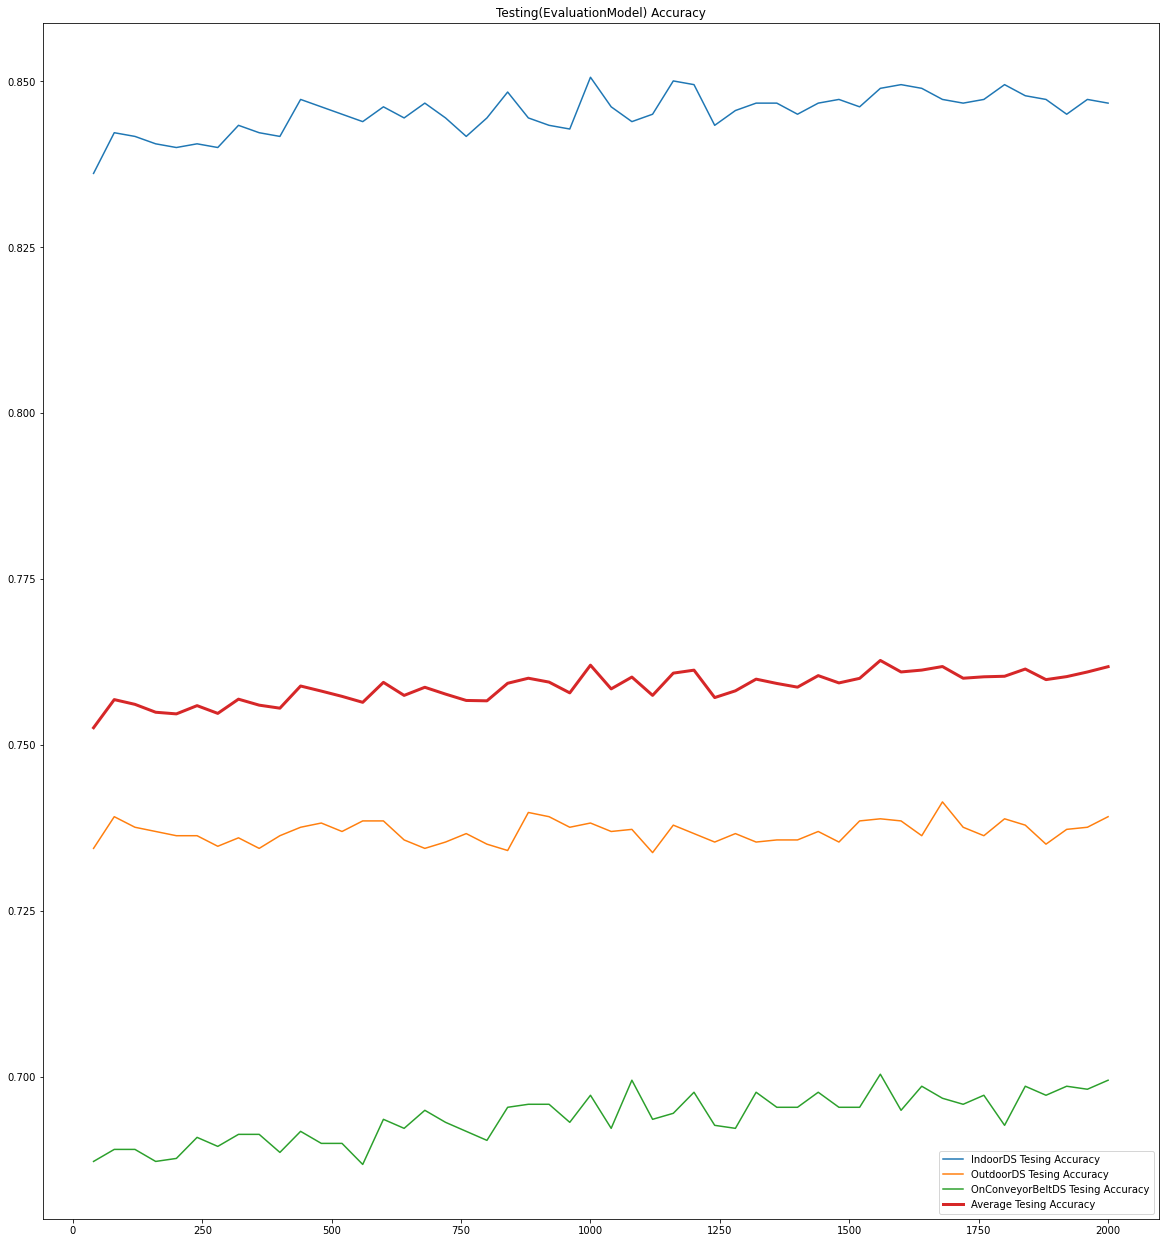

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7627190152804056
max index -> 38
The [Epoch] of max acc -> 1560


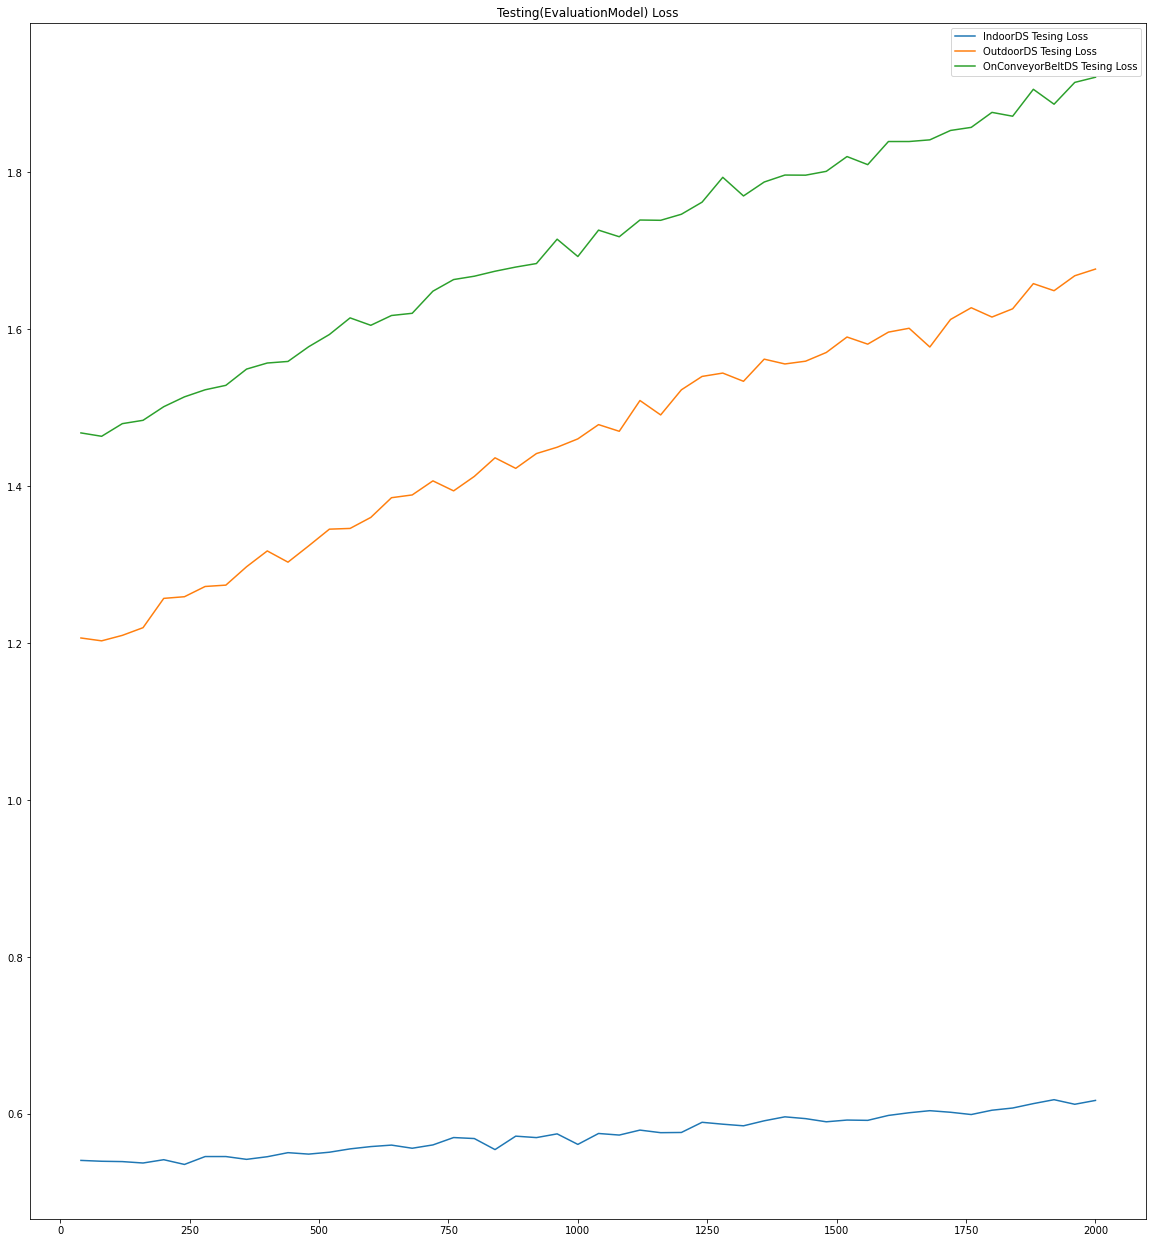

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8361204266548157,
 0.8422519564628601,
 0.8416945338249207,
 0.8405796885490417,
 0.8400223255157471,
 0.8405796885490417,
 0.8400223255157471,
 0.843366801738739,
 0.8422519564628601,
 0.8416945338249207,
 0.8472687005996704,
 0.8461538553237915,
 0.8450390100479126,
 0.8439241647720337,
 0.8461538553237915,
 0.8444815874099731,
 0.846711277961731,
 0.8444815874099731,
 0.8416945338249207,
 0.8444815874099731,
 0.8483834862709045,
 0.8444815874099731,
 0.843366801738739,
 0.8428093791007996,
 0.8506131768226624,
 0.8461538553237915,
 0.8439241647720337,
 0.8450390100479126,
 0.8500557541847229,
 0.8494983315467834,
 0.843366801738739,
 0.845596432685852,
 0.846711277961731,
 0.846711277961731,
 0.8450390100479126,
 0.846711277961731,
 0.8472687005996704,
 0.8461538553237915,
 0.848940908908844,
 0.8494983315467834,
 0.848940908908844,
 0.8472687005996704,
 0.846711277961731,
 0.8472687005996704,
 0.8494983315467834,
 0.8478260636329651,
 0.8472687005996704,
 0.8450390100479126,
 0.

In [38]:
test_outdoor_acc

[0.734394907951355,
 0.7391719818115234,
 0.7375796437263489,
 0.7369426488876343,
 0.7363057136535645,
 0.7363057136535645,
 0.7347133755683899,
 0.7359872460365295,
 0.734394907951355,
 0.7363057136535645,
 0.7375796437263489,
 0.7382165789604187,
 0.7369426488876343,
 0.7385350465774536,
 0.7385350465774536,
 0.7356687784194946,
 0.734394907951355,
 0.7353503108024597,
 0.7366241812705994,
 0.7350318431854248,
 0.7340764403343201,
 0.7398089170455933,
 0.7391719818115234,
 0.7375796437263489,
 0.7382165789604187,
 0.7369426488876343,
 0.737261176109314,
 0.7337579727172852,
 0.7378981113433838,
 0.7366241812705994,
 0.7353503108024597,
 0.7366241812705994,
 0.7353503108024597,
 0.7356687784194946,
 0.7356687784194946,
 0.7369426488876343,
 0.7353503108024597,
 0.7385350465774536,
 0.7388535141944885,
 0.7385350465774536,
 0.7363057136535645,
 0.7414012551307678,
 0.7375796437263489,
 0.7363057136535645,
 0.7388535141944885,
 0.7378981113433838,
 0.7350318431854248,
 0.73726117610931

In [39]:
test_belt_acc

[0.6872166991233826,
 0.6890299320220947,
 0.6890299320220947,
 0.6872166991233826,
 0.6876699924468994,
 0.6908431649208069,
 0.6894832253456116,
 0.6912964582443237,
 0.6912964582443237,
 0.6885766386985779,
 0.6917497515678406,
 0.6899365186691284,
 0.6899365186691284,
 0.686763346195221,
 0.6935629844665527,
 0.6922031044960022,
 0.694922924041748,
 0.6931096911430359,
 0.6917497515678406,
 0.69038987159729,
 0.6953762173652649,
 0.6958295702934265,
 0.6958295702934265,
 0.6931096911430359,
 0.6971895098686218,
 0.6922031044960022,
 0.6994560360908508,
 0.6935629844665527,
 0.6944696307182312,
 0.6976428031921387,
 0.692656397819519,
 0.6922031044960022,
 0.6976428031921387,
 0.6953762173652649,
 0.6953762173652649,
 0.6976428031921387,
 0.6953762173652649,
 0.6953762173652649,
 0.7003626227378845,
 0.694922924041748,
 0.6985493898391724,
 0.6967361569404602,
 0.6958295702934265,
 0.6971895098686218,
 0.692656397819519,
 0.6985493898391724,
 0.6971895098686218,
 0.6985493898391724,

In [40]:
test_indoor_loss

[0.5410284399986267,
 0.539940357208252,
 0.5395131707191467,
 0.5377098917961121,
 0.5419188737869263,
 0.5358885526657104,
 0.5459404587745667,
 0.5459470152854919,
 0.5423687696456909,
 0.5457198023796082,
 0.5508904457092285,
 0.5490512251853943,
 0.5514665842056274,
 0.5557152032852173,
 0.558650553226471,
 0.5605285167694092,
 0.5565313696861267,
 0.5607652068138123,
 0.5701549053192139,
 0.5688899159431458,
 0.5548112392425537,
 0.5719373226165771,
 0.5700932145118713,
 0.5748475193977356,
 0.561434805393219,
 0.5753434896469116,
 0.5733227729797363,
 0.5796485543251038,
 0.576366126537323,
 0.5766287446022034,
 0.5895905494689941,
 0.5871782898902893,
 0.5851171016693115,
 0.5914971828460693,
 0.5965595841407776,
 0.5942686796188354,
 0.5902368426322937,
 0.5924456715583801,
 0.5920690298080444,
 0.5983515977859497,
 0.6017590761184692,
 0.6043892502784729,
 0.6023838520050049,
 0.5994907021522522,
 0.604989230632782,
 0.6077868342399597,
 0.6134088039398193,
 0.618400514125824

In [41]:
test_outdoor_loss

[1.2067934274673462,
 1.2031543254852295,
 1.2101285457611084,
 1.2199273109436035,
 1.2572641372680664,
 1.2593791484832764,
 1.2724355459213257,
 1.2741526365280151,
 1.2975870370864868,
 1.3177332878112793,
 1.3034251928329468,
 1.324177861213684,
 1.3454731702804565,
 1.3464124202728271,
 1.3604440689086914,
 1.3855640888214111,
 1.3890786170959473,
 1.407025694847107,
 1.3942737579345703,
 1.412693738937378,
 1.4363871812820435,
 1.4229766130447388,
 1.4418107271194458,
 1.449894905090332,
 1.4605298042297363,
 1.4787025451660156,
 1.4702128171920776,
 1.5094162225723267,
 1.4910504817962646,
 1.5230305194854736,
 1.5401194095611572,
 1.5443885326385498,
 1.5339081287384033,
 1.5621321201324463,
 1.5560088157653809,
 1.5595388412475586,
 1.5706425905227661,
 1.590339183807373,
 1.5812512636184692,
 1.596574068069458,
 1.6014808416366577,
 1.5776056051254272,
 1.6127067804336548,
 1.6276514530181885,
 1.615785837173462,
 1.6263025999069214,
 1.6583839654922485,
 1.649354338645935,


In [42]:
test_belt_loss

[1.4681323766708374,
 1.4638324975967407,
 1.47994065284729,
 1.4841915369033813,
 1.5015339851379395,
 1.5140818357467651,
 1.5230892896652222,
 1.5287619829177856,
 1.5494582653045654,
 1.5572012662887573,
 1.559208631515503,
 1.5779716968536377,
 1.5935332775115967,
 1.6147319078445435,
 1.6052652597427368,
 1.6177632808685303,
 1.620571255683899,
 1.6487482786178589,
 1.6635624170303345,
 1.6678327322006226,
 1.6741750240325928,
 1.6794875860214233,
 1.6839711666107178,
 1.7150135040283203,
 1.6929351091384888,
 1.7265443801879883,
 1.7181166410446167,
 1.7394355535507202,
 1.7390742301940918,
 1.7467851638793945,
 1.7622108459472656,
 1.7938624620437622,
 1.7701160907745361,
 1.7878599166870117,
 1.7967478036880493,
 1.7965842485427856,
 1.8014857769012451,
 1.8203123807907104,
 1.81001615524292,
 1.839470624923706,
 1.8394832611083984,
 1.8416029214859009,
 1.8535892963409424,
 1.8575092554092407,
 1.8766074180603027,
 1.8717236518859863,
 1.9060295820236206,
 1.8870264291763306,

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1560-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [16]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5387
FP=1753
acc=0.7544817927170868
all check = 7140


In [17]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 68.96551724137932%
2WayConnectorforFoley acc = 89.79591836734694%
2WayFoleyCatheter acc = 66.4179104477612%
3WayConnectorforFoley acc = 89.74358974358975%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 84.375%
AlcoholPad acc = 46.03174603174603%
BootCover acc = 68.67469879518072%
CottonBall acc = 82.03592814371258%
CottonSwap acc = 80.41958041958041%
Dilator acc = 74.35897435897436%
DisposableInfusionSet acc = 54.86725663716814%
ExtensionTube acc = 27.64227642276423%
FaceShield acc = 73.4567901234568%
FrontLoadSyringe acc = 58.4070796460177%
GauzePad acc = 59.65909090909091%
Glove acc = 76.19047619047619%
GuideWire acc = 28.57142857142857%
LiquidBottle acc = 62.97709923664122%
Mask acc = 94.54545454545455%
NGTube acc = 42.58064516129032%
NasalCannula acc = 66.3716814159292%
Needle acc = 83.21428571428572%
OxygenMask acc = 96.99248120300751%
PPESuit acc = 96.7741935483871%
PharmaceuticalProduct acc = 62.616822429906534%
Pill acc = 96.9187675070028%
PillBottle 

In [18]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 80,   0,   0, ...,   0,   0,   0],
       [  0, 132,   0, ...,   0,   0,   0],
       [  0,   0,  89, ...,   0,   2,  13],
       ...,
       [  0,   0,   0, ...,  77,   0,   1],
       [  0,   0,   0, ...,   1, 182,   0],
       [  0,   0,   0, ...,   0,   0,  77]], dtype=int64)

In [19]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[68.96551724,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 89.79591837,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 66.41791045, ...,  0.        ,
         1.49253731,  9.70149254],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 64.16666667,
         0.        ,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        85.44600939,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 67.54385965]])

<AxesSubplot:>

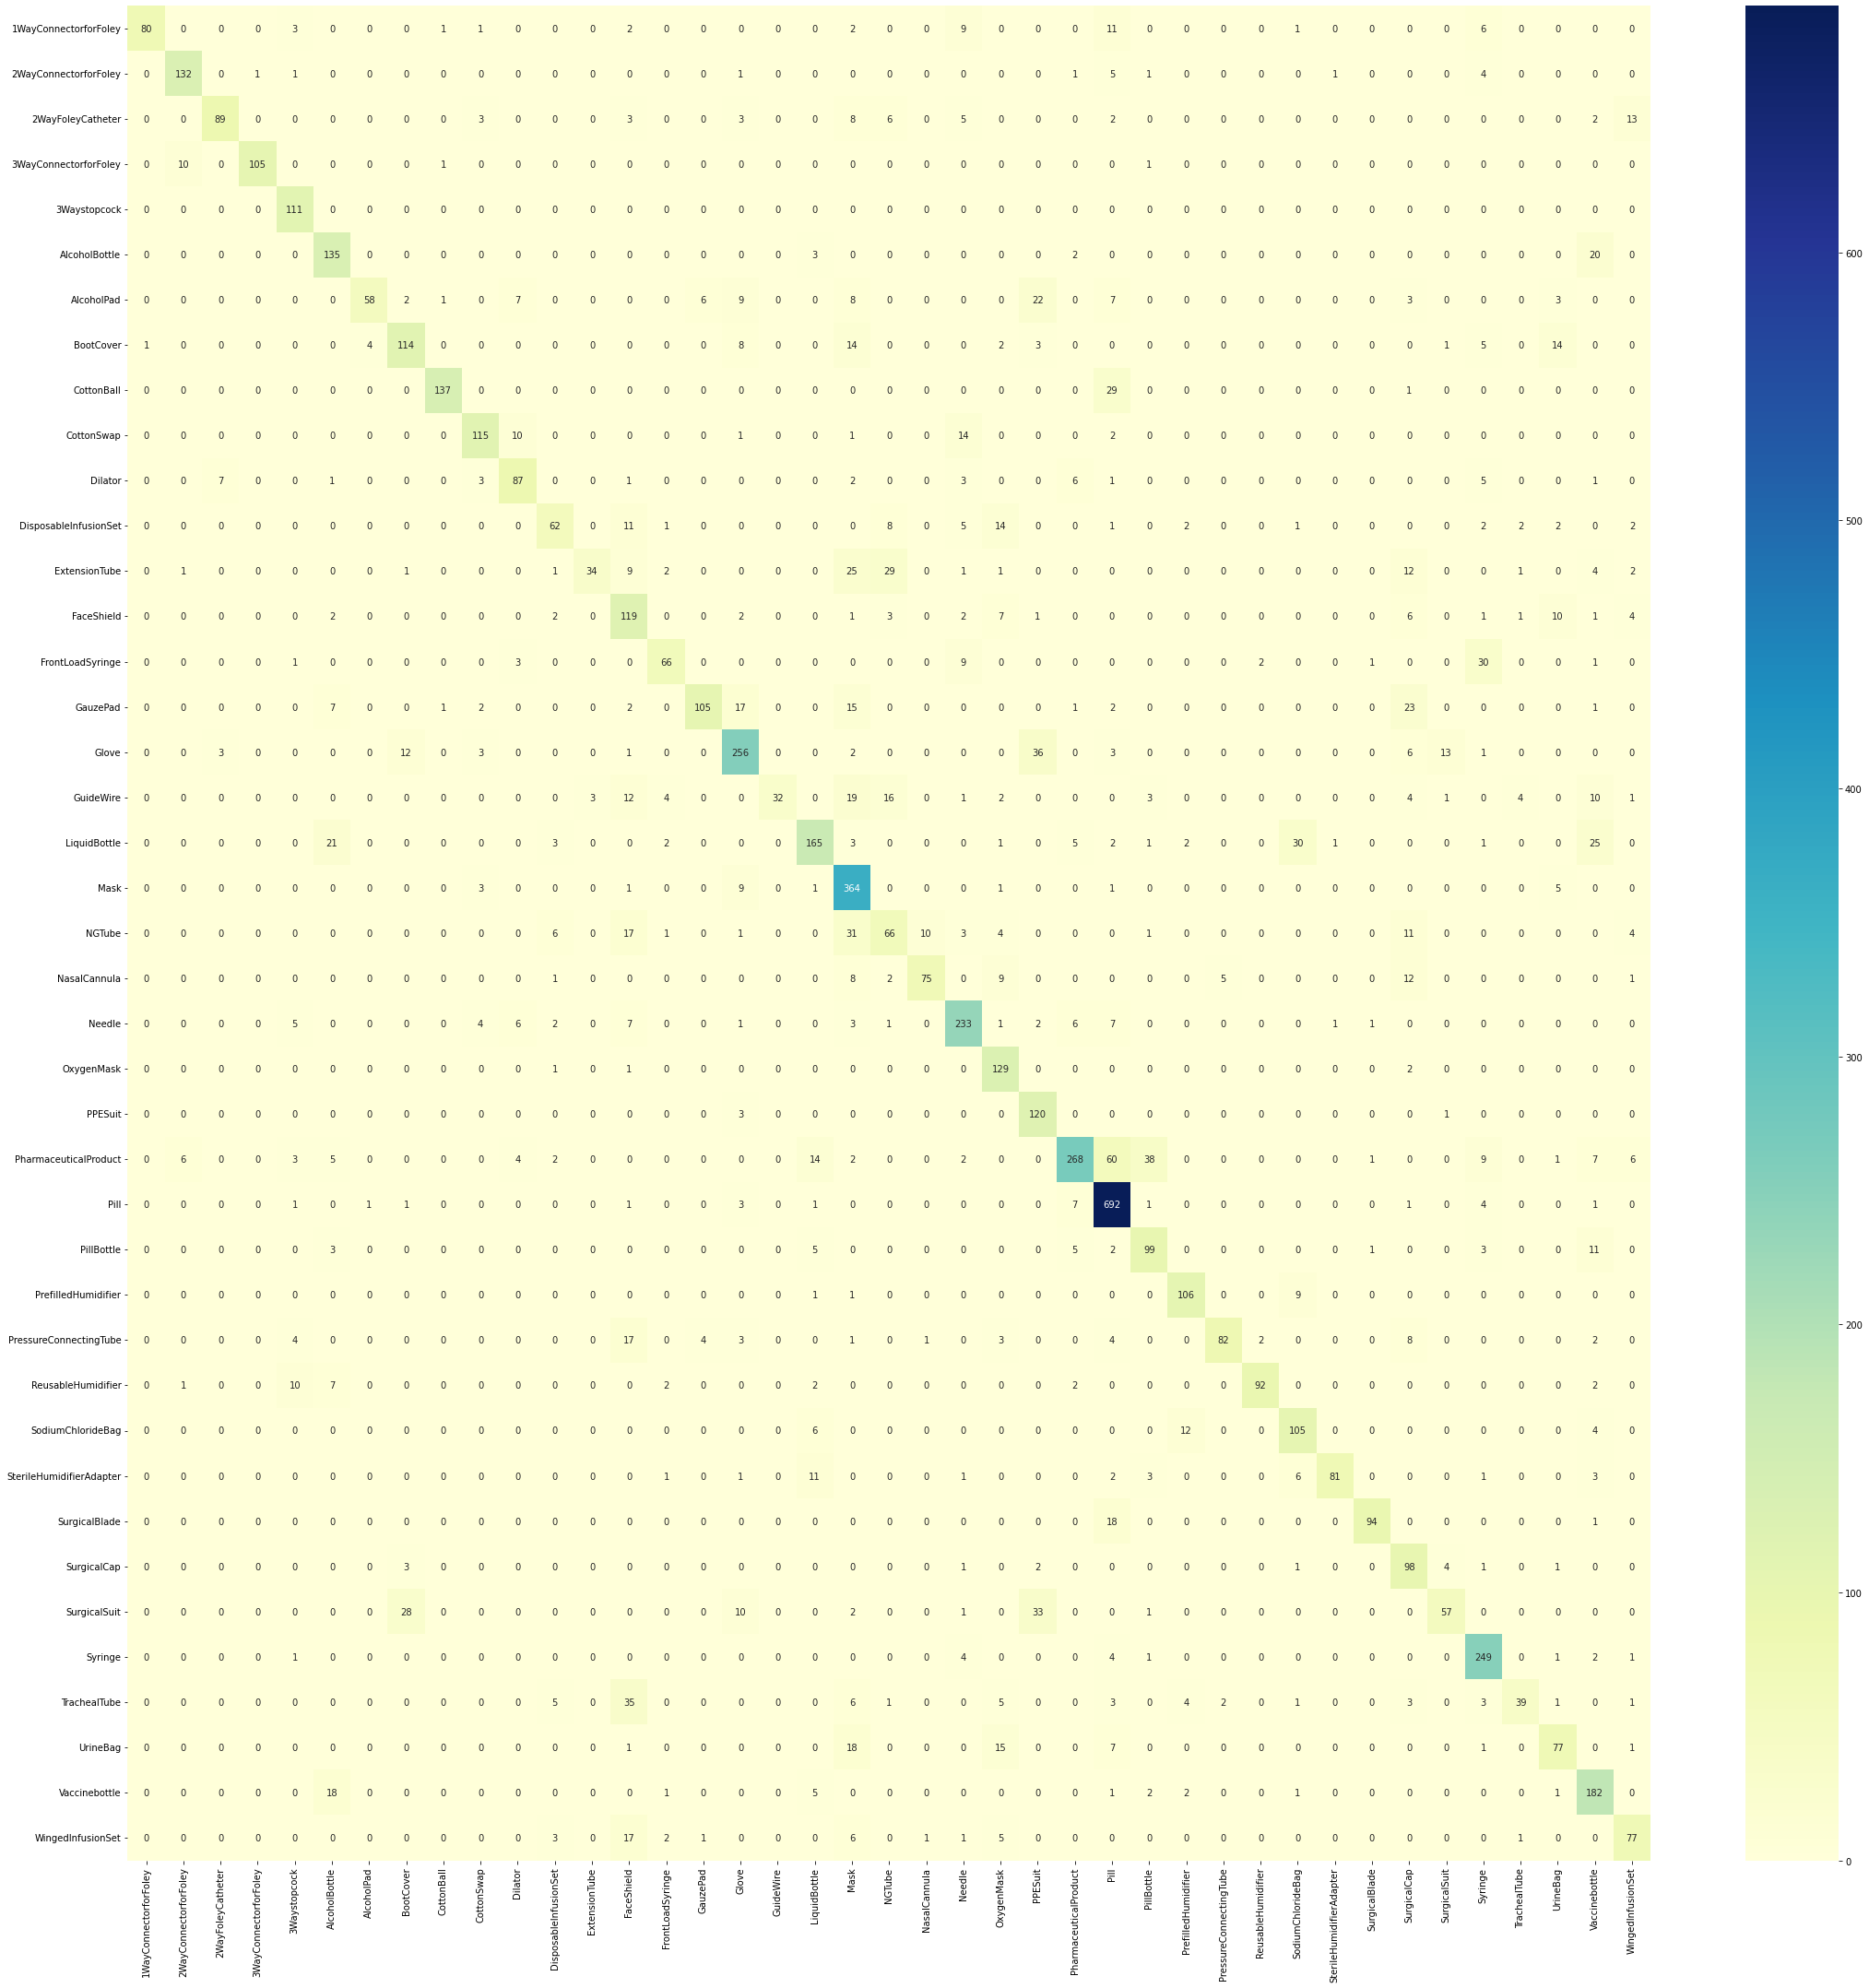

In [20]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

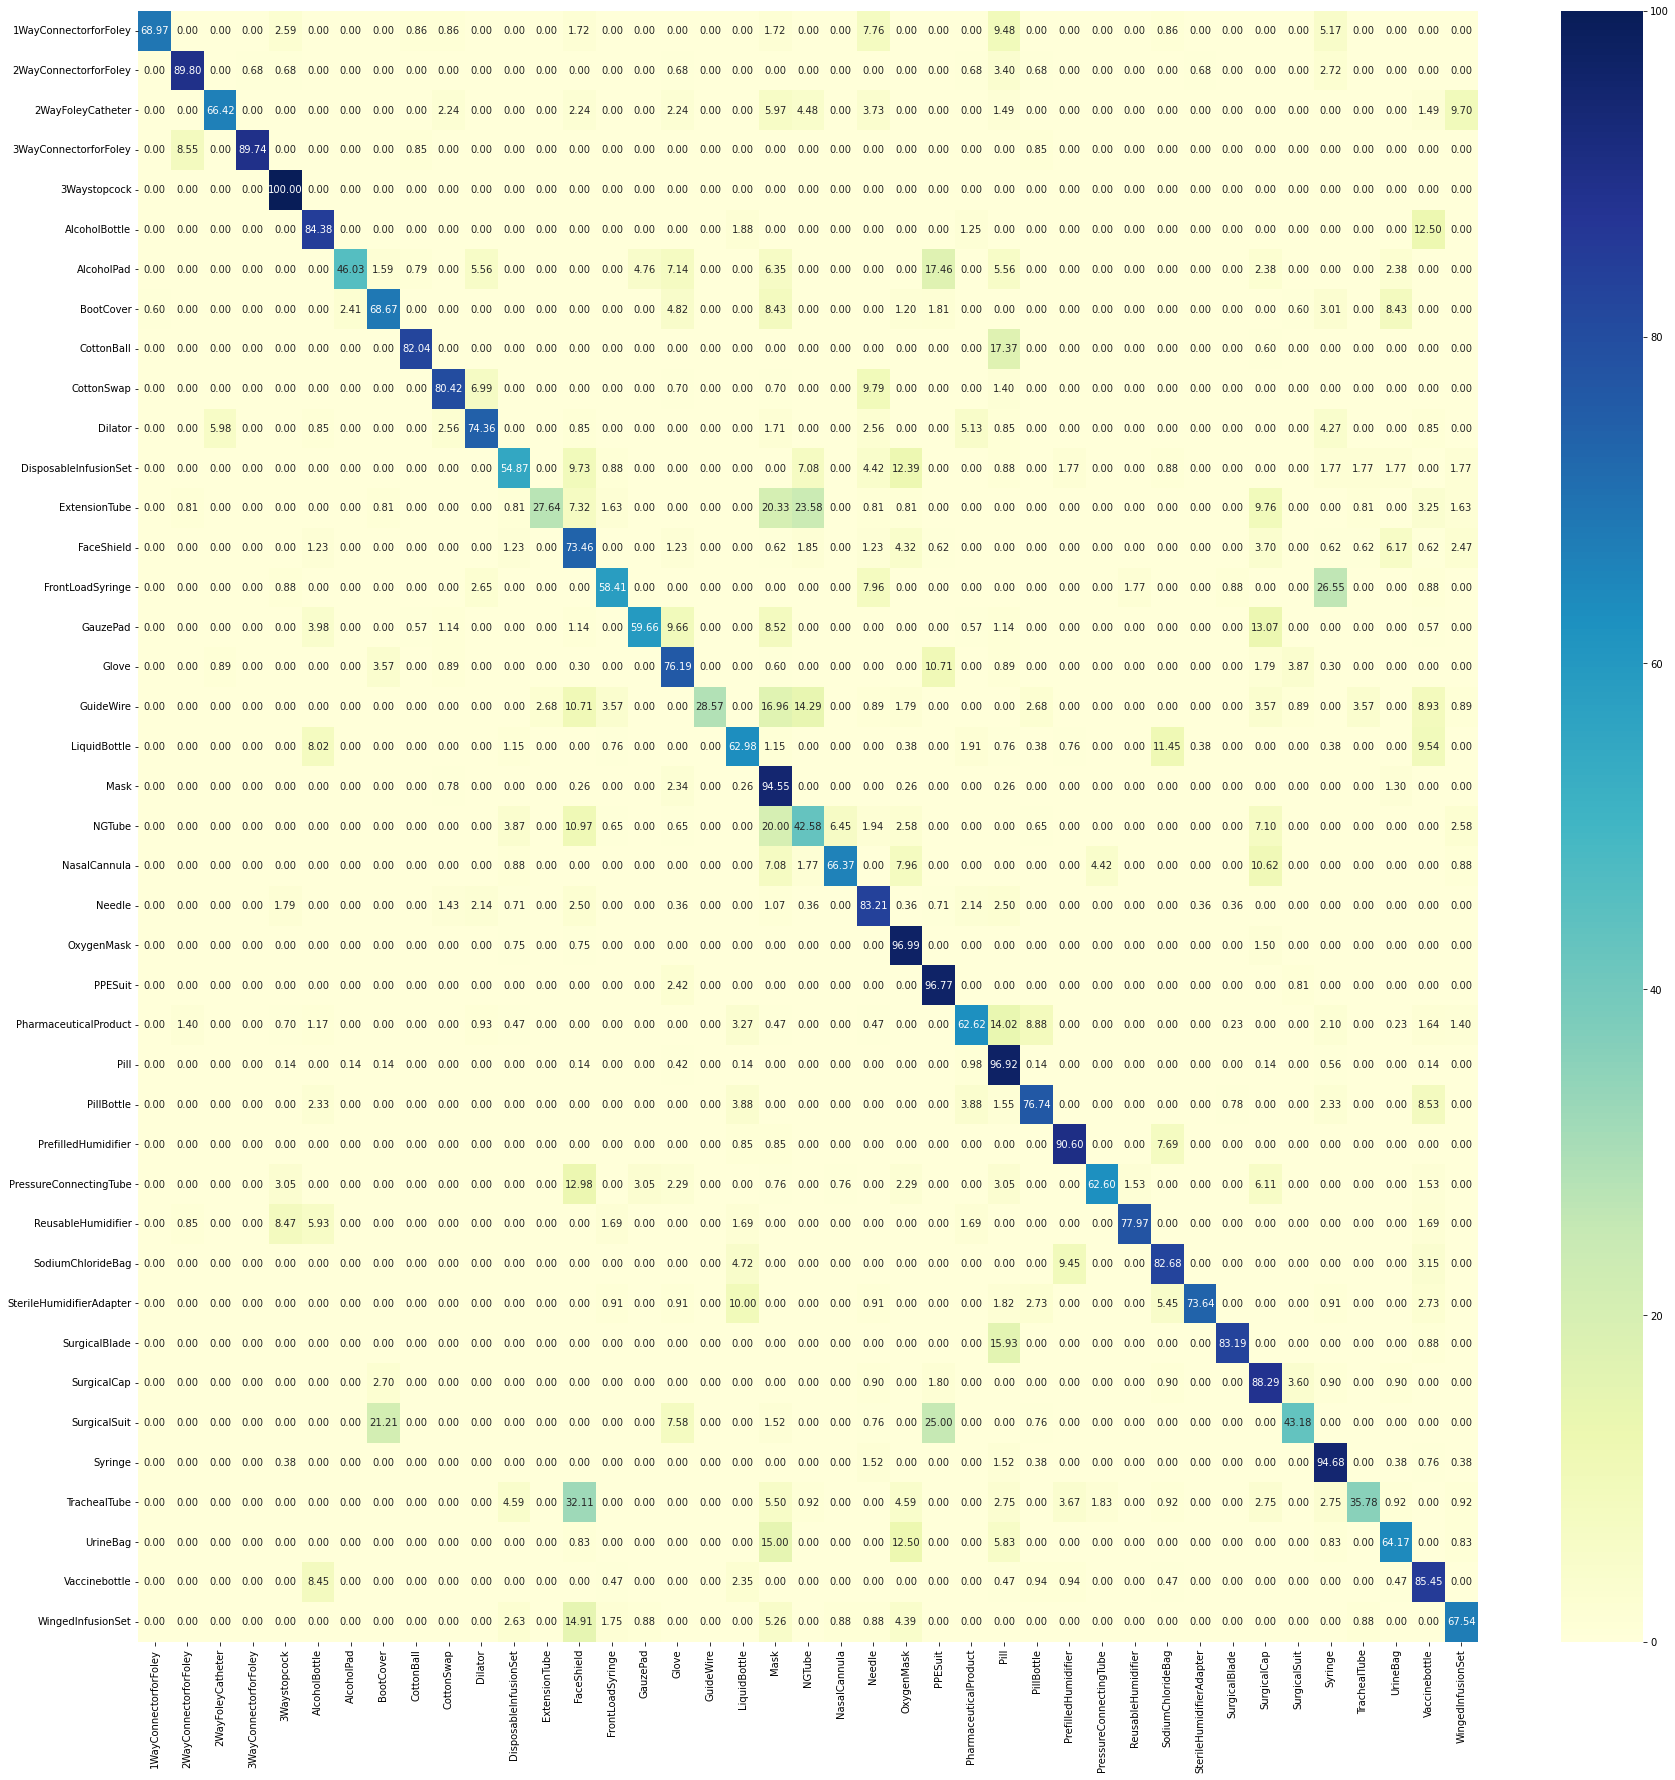

In [21]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")